In [78]:
library(tidyverse)
library(repr)
library(tidymodels)

In [79]:
data <- read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vSTyupJYW8-dOI7rTKOVE-bMT4M_8UnVnRLOJGavyVh33-4wHTkP4Q-uWX9mwMQul2kxMl8aJLR0FHB/pub?output=csv")

Parsed with column specification:
cols(
  .default = col_double(),
  url = col_character()
)

See spec(...) for full column specifications.



In [80]:


named_data <- data %>%
    rename(
        monday = weekday_is_monday,
        tuesday = weekday_is_tuesday,
        wednesday = weekday_is_wednesday,
        thursday = weekday_is_thursday,
        friday = weekday_is_friday,
        saturday = weekday_is_saturday,
        sunday = weekday_is_sunday,
        lifestyle = data_channel_is_lifestyle,
        entertainment =  data_channel_is_entertainment,
        business = data_channel_is_bus,
        society_and_medicine =  data_channel_is_socmed,
        technology =  data_channel_is_tech,
        world =  data_channel_is_world,
    )


In [81]:
#It didn't work when all in one pipe, I have no idea why. This seems to work though
tidy_data <- named_data %>%
    pivot_longer(cols =  lifestyle:world, 
                 names_to = 'Genre', 
                 values_to = 'Genre_Present') %>%
    filter(Genre_Present == 1) %>%
    pivot_longer(cols =   monday:sunday, 
                 names_to = 'Day_Of_Week', 
                 values_to = 'Day_Present') %>%
    filter(Day_Present == 1) %>%
    mutate(Genre = as_factor(Genre)) %>%
    mutate(Day_Of_Week = as_factor(Day_Of_Week))%>%
    mutate (Popular = shares > 3000)%>%
    mutate(Popular = as_factor(Popular)) %>%
    mutate(Unpopular = shares <2999)%>%
    mutate(Unpopular = as_factor(Unpopular)) %>%
    select(Genre, Day_Of_Week, shares, Popular, num_keywords, n_unique_tokens,n_tokens_content, n_tokens_title, average_token_length)

head(tidy_data)
nrow(tidy_data)

Genre,Day_Of_Week,shares,Popular,num_keywords,n_unique_tokens,n_tokens_content,n_tokens_title,average_token_length
<fct>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
entertainment,monday,593,FALSE,5,0.6635945,219,12,4.680365
business,monday,711,FALSE,4,0.6047431,255,9,4.913725
business,monday,1500,FALSE,6,0.5751295,211,9,4.393365
entertainment,monday,1200,FALSE,7,0.5037879,531,9,4.404896
technology,monday,505,FALSE,7,0.4156456,1072,13,4.682836
technology,monday,855,FALSE,9,0.5598886,370,10,4.359459


[1] 33510

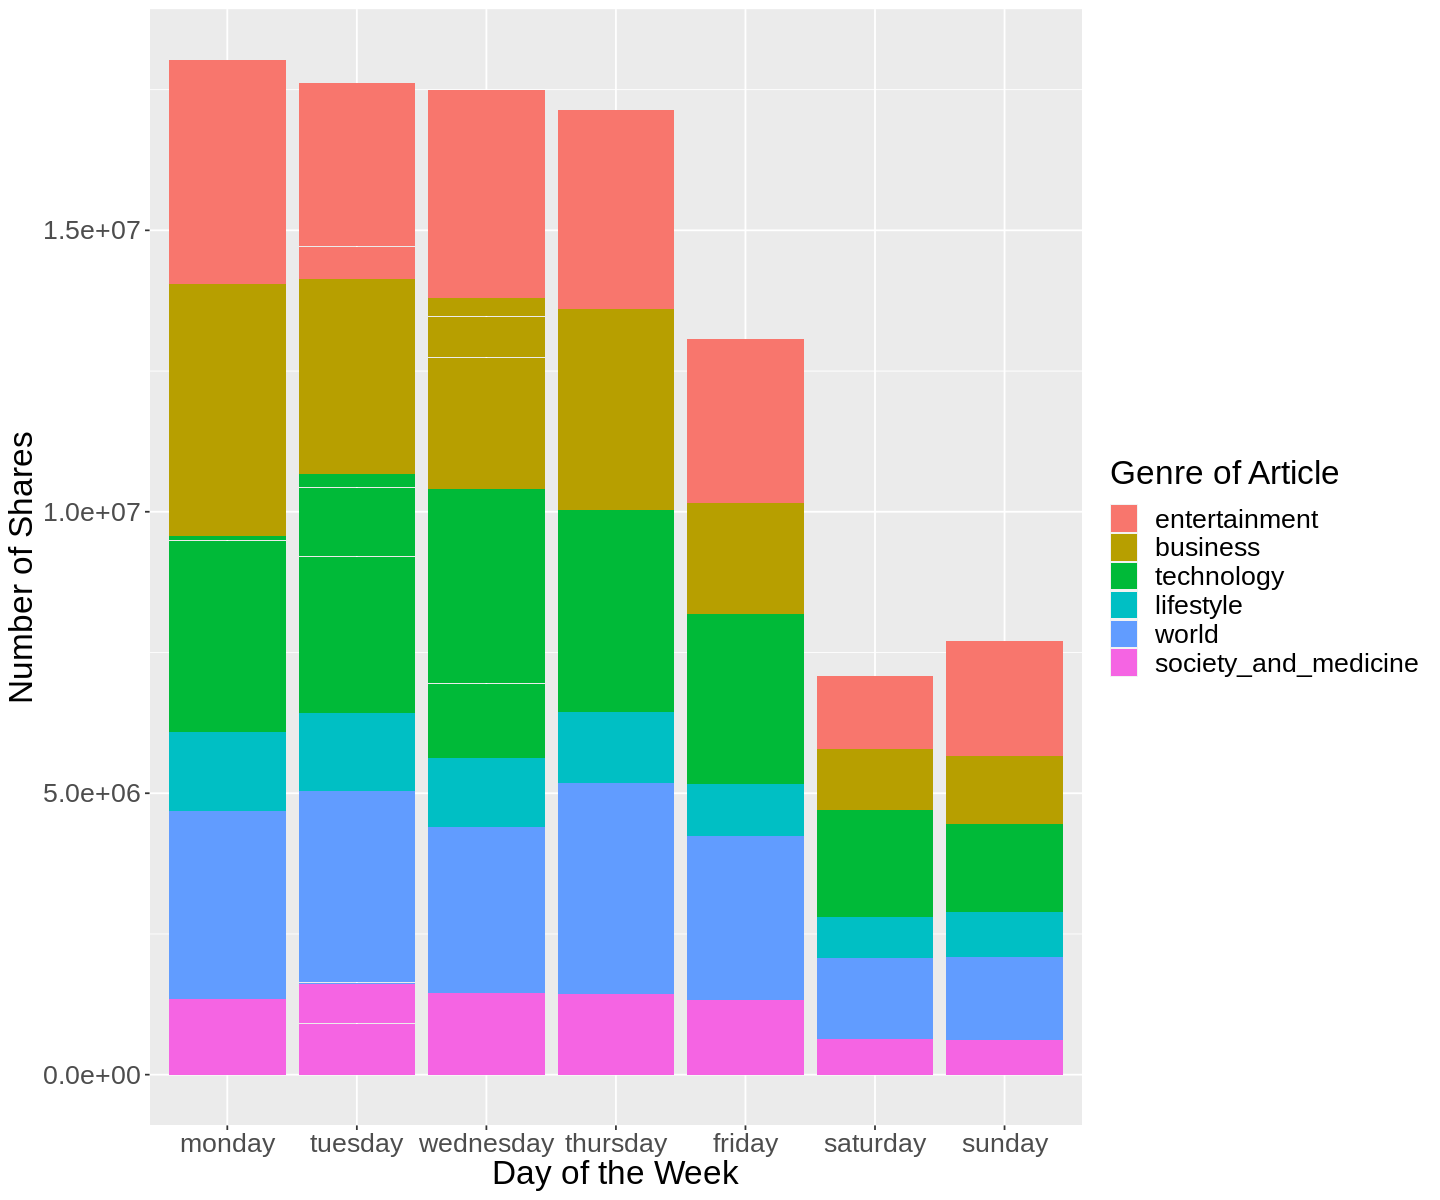

In [82]:
options(repr.plot.width = 12, repr.plot.height = 10)
publish_plot <- tidy_data %>%
    ggplot(aes(x = Day_Of_Week, y = shares, fill = Genre)) + 
    geom_bar(stat = 'identity') +
    xlab("Day of the Week") +
    ylab("Number of Shares") +
    labs(fill = "Genre of Article") +
    theme(text = element_text(size = 20))

publish_plot

PREDICT WHETHER A GENRE OF ARTICLE IS POPULAR OR NOT 

In [83]:
set.seed(1234)
publishing_split <- initial_split(tidy_data, prop = 0.75, strata = Popular)
publishing_train <- training(publishing_split)
publishing_test <- testing(publishing_split)

head(publishing_train)
    nrow(publishing_train)


Genre,Day_Of_Week,shares,Popular,num_keywords,n_unique_tokens,n_tokens_content,n_tokens_title,average_token_length
<fct>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
entertainment,monday,593,FALSE,5,0.6635945,219,12,4.680365
business,monday,711,FALSE,4,0.6047431,255,9,4.913725
business,monday,1500,FALSE,6,0.5751295,211,9,4.393365
entertainment,monday,1200,FALSE,7,0.5037879,531,9,4.404896
technology,monday,505,FALSE,7,0.4156456,1072,13,4.682836
technology,monday,855,FALSE,9,0.5598886,370,10,4.359459


[1] 25133

In [84]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
       set_engine("kknn") %>%
       set_mode("classification") 

share_recipe <- recipe(Popular ~ num_keywords, data = publishing_train) %>%
       step_scale(all_predictors()) %>%
       step_center(all_predictors())
share_recipe

shares_vfold <- vfold_cv(publishing_train, v = 5, strata = Popular)
gridvals <- tibble(neighbors = seq(1,20))

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          1

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [85]:
knn_results <- workflow() %>%
    add_recipe(share_recipe)%>%
    add_model(knn_spec) %>%
    tune_grid(resamples = shares_vfold, grid = gridvals) %>%
    collect_metrics()

knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.7221963,5,3.615076e-02,Model01
1,roc_auc,binary,0.4973456,5,3.575037e-03,Model01
2,accuracy,binary,0.7218381,5,3.617015e-02,Model02
2,roc_auc,binary,0.4892013,5,5.562610e-03,Model02
3,accuracy,binary,0.7360040,5,2.636045e-02,Model03
3,roc_auc,binary,0.4857558,5,5.487597e-03,Model03
4,accuracy,binary,0.7360040,5,2.636045e-02,Model04
4,roc_auc,binary,0.4889063,5,4.732871e-03,Model04
5,accuracy,binary,0.7761083,5,2.346402e-02,Model05


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
6,accuracy,binary,0.7995862,5,3.465803e-05,Model06
7,accuracy,binary,0.7995862,5,3.465803e-05,Model07
8,accuracy,binary,0.7995862,5,3.465803e-05,Model08
9,accuracy,binary,0.7995862,5,3.465803e-05,Model09
10,accuracy,binary,0.7995862,5,3.465803e-05,Model10
11,accuracy,binary,0.7995862,5,3.465803e-05,Model11
12,accuracy,binary,0.7995862,5,3.465803e-05,Model12
13,accuracy,binary,0.7995862,5,3.465803e-05,Model13
14,accuracy,binary,0.7995862,5,3.465803e-05,Model14


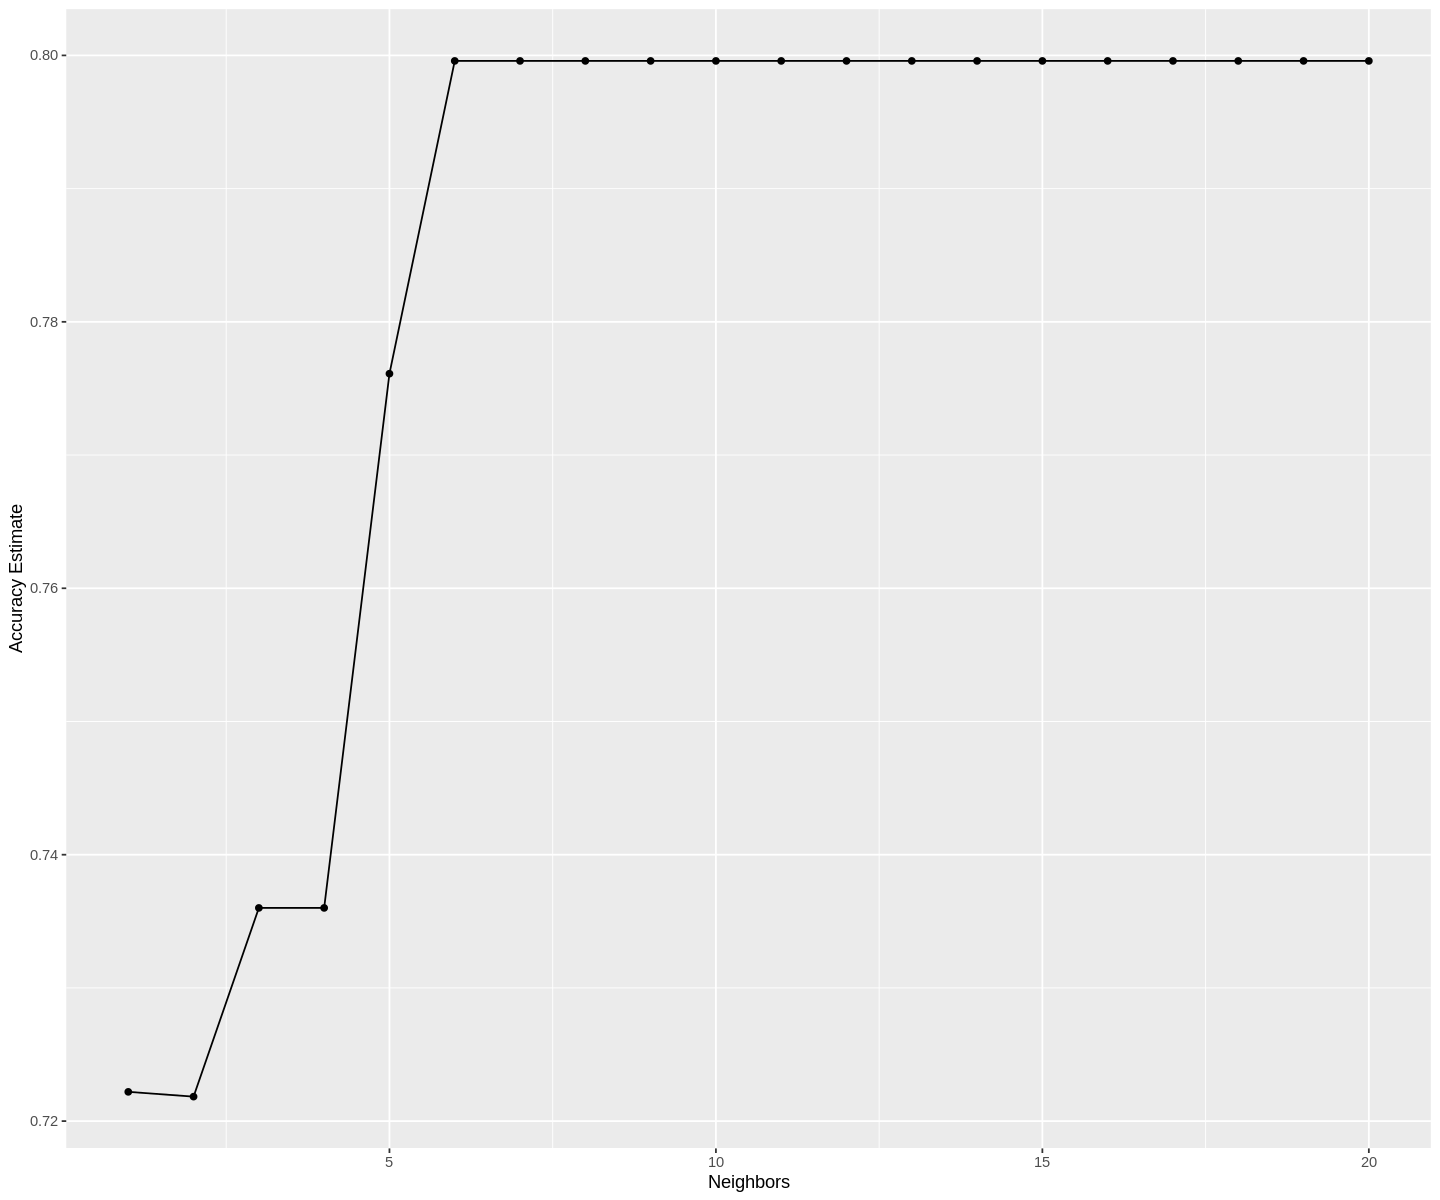

In [86]:
accuracies <- knn_results %>%
  filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate")
accuracy_vs_k
filter(accuracies, mean ==max(mean))

In [96]:
share_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) %>% 
       set_engine("kknn") %>%
       set_mode("classification") 

In [105]:
share_recipe <- recipe(Popular ~ num_keywords, data = publishing_train) %>%
       step_scale(all_predictors()) %>%
       step_center(all_predictors())
share_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          1

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [106]:
share_workflow <-workflow()%>%
    add_model(share_spec)%>%
    add_recipe(share_recipe)

share_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 6
  weight_func = rectangular

Computational engine: kknn 


In [107]:
share_fit <- fit(share_workflow, data = publishing_train)
share_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~6, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2004138
Best kernel: rectangular
Best k: 6

In [108]:
share_test_predictions <- predict(share_fit, publishing_test) %>%
  bind_cols(publishing_test)
share_test_predictions

.pred_class,Genre,Day_Of_Week,shares,Popular,num_keywords,n_unique_tokens,n_tokens_content,n_tokens_title,average_token_length
<fct>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FALSE,technology,monday,3600,TRUE,7,0.6701031,97,11,4.855670
FALSE,business,monday,3200,TRUE,7,0.4822191,708,8,4.620056
FALSE,technology,monday,480,FALSE,9,0.6115108,290,14,4.068966
FALSE,technology,monday,695,FALSE,9,0.4085923,1108,11,4.654332
FALSE,technology,monday,400,FALSE,9,0.4222441,1030,9,4.700971
FALSE,technology,monday,1300,FALSE,9,0.8217054,130,8,4.546154
FALSE,business,monday,819,FALSE,10,0.6009174,444,12,4.810811
FALSE,technology,monday,536,FALSE,10,0.4280079,1024,13,4.778320
FALSE,technology,monday,3200,TRUE,8,0.5160428,403,8,4.081886


In [109]:
share_test_predictions %>%
  metrics(truth = Popular, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7995703
kap,binary,0.0000000


In [110]:
popular_to_unpopular_ratio <- publishing_train%>%
    group_by(Popular)%>%
    summarize(count = n())
popular_to_unpopular_ratio

`summarise()` ungrouping output (override with `.groups` argument)



Popular,count
<fct>,<int>
FALSE,20096
TRUE,5037


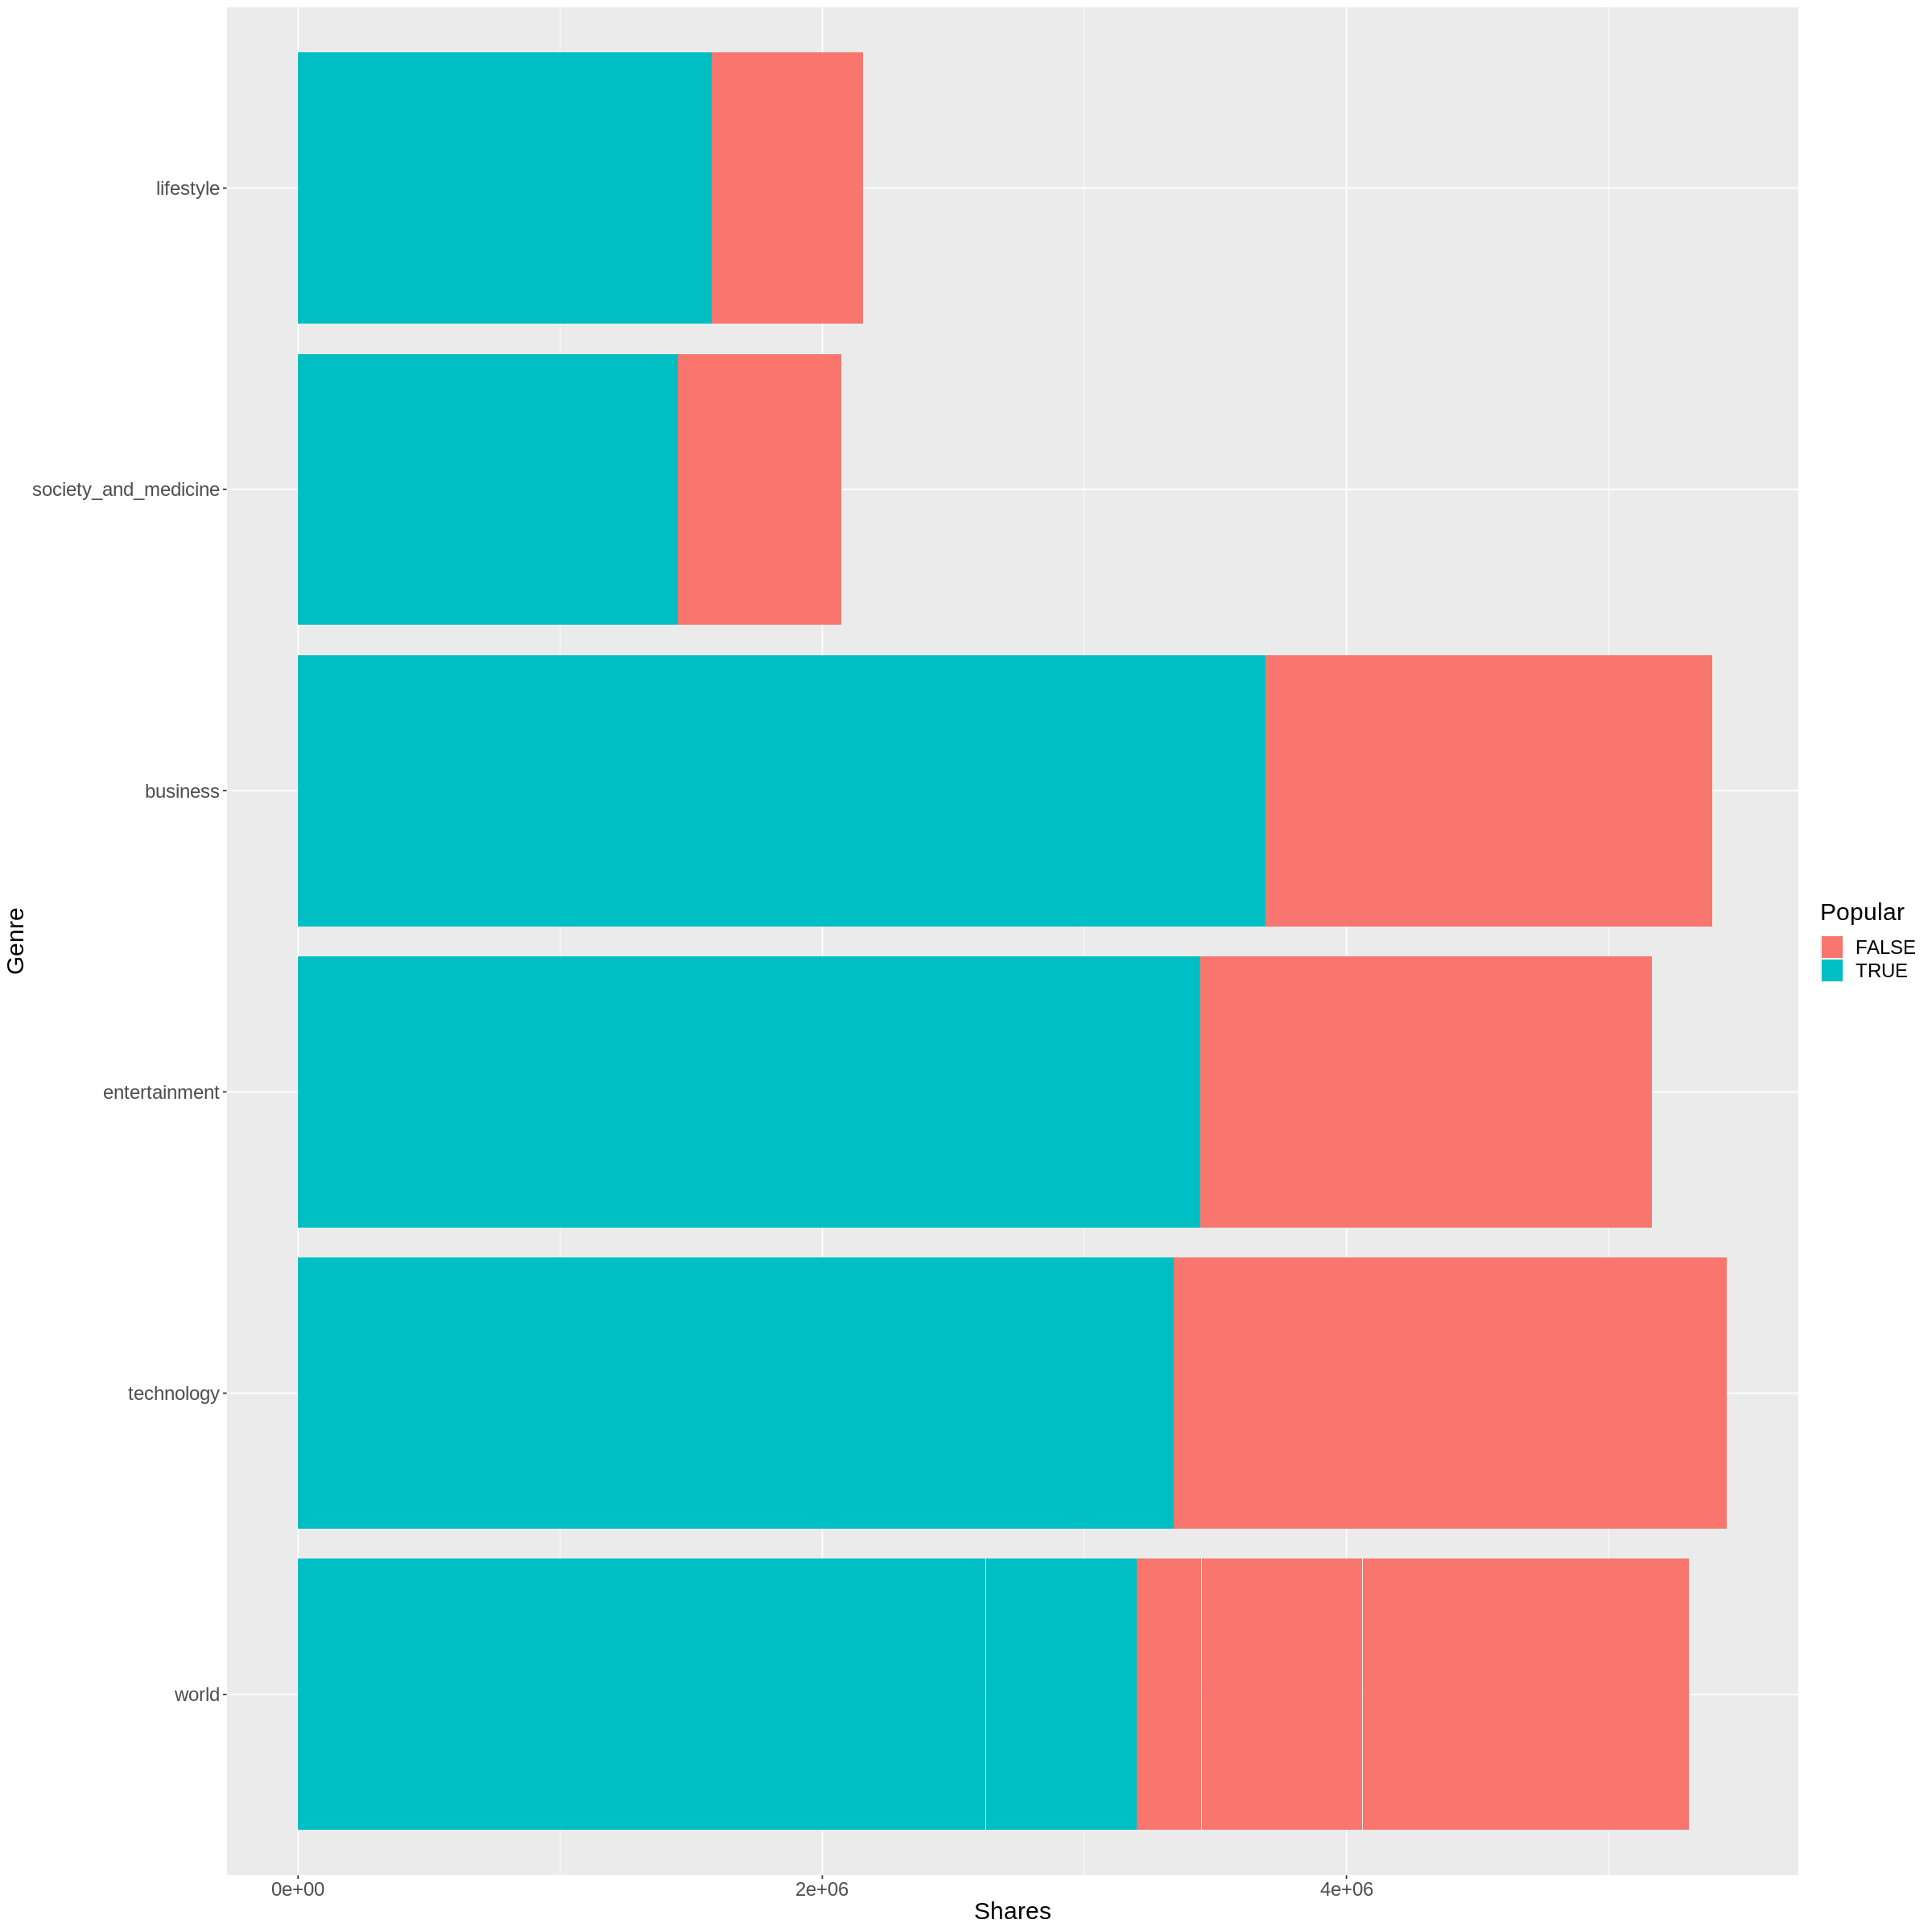

In [111]:
options(repr.plot.width = 20, repr.plot.height = 20)


share_plot <- ggplot(share_test_predictions, aes(x = reorder(Genre, shares), y = shares, fill = Popular)) +
    geom_bar(stat = "identity") +
    labs(x = "Genre", y = "Shares",  fill = "Popular") +
    theme(text = element_text(size = 18))+
    coord_flip()
share_plot

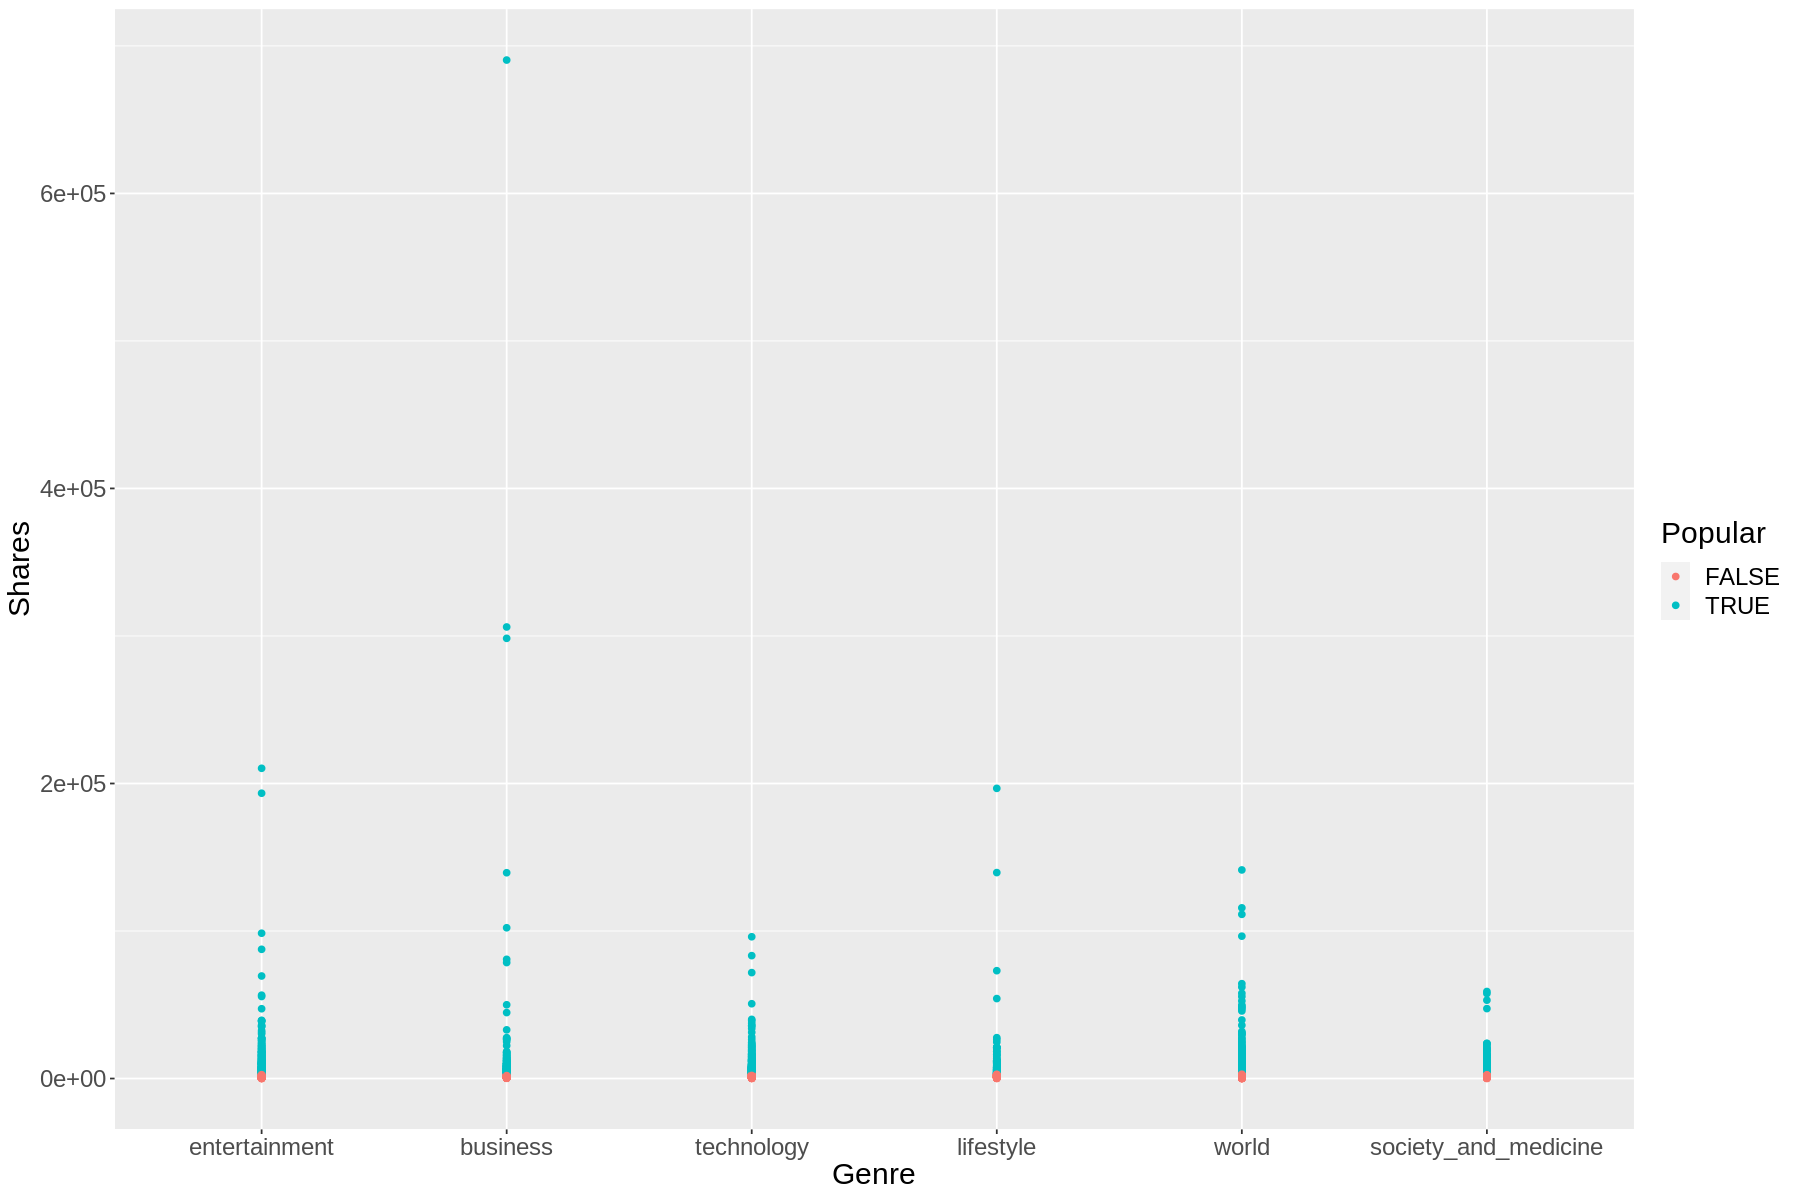

In [112]:
options(repr.plot.width = 15, repr.plot.height = 10)
share_plot_scatter <- ggplot(share_test_predictions, aes(x = Genre, y = shares, color = Popular)) +
    geom_point() +
    labs(x = "Genre", y = "Shares",  fill = "Popular") +
    theme(text = element_text(size = 18))
share_plot_scatter